Chargement des données et préparation pour le modèle Machine Learning

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# 1. Chargement des données préprocessées
print("Chargement des données...")
X = np.load('/content/drive/MyDrive/data/preprocessed/X_train.npy')
y = np.load('/content/drive/MyDrive/data/preprocessed/y_train.npy')

Chargement des données...


In [ ]:
# Vérification des dimensions
print(f"Shape de X: {X.shape} | Shape de y: {y.shape}")


Shape de X: (5619, 224, 224, 1) | Shape de y: (5619,)


Réduction de dimension avec PCA pour accélérer l'entraînement

In [ ]:
# 2. Réduction de dimension si nécessaire (pour accélérer l'entraînement)
def apply_pca(X, n_components=0.95):
    """Applique PCA pour conserver 95% de la variance"""
    original_shape = X.shape
    X_flat = X.reshape(X.shape[0], -1)  # Aplatir les images

    pca = PCA(n_components=n_components, random_state=42)
    X_reduced = pca.fit_transform(X_flat)

    print(f"Réduction PCA : {X_flat.shape[1]} features → {X_reduced.shape[1]} features")
    print(f"Variance expliquée : {np.sum(pca.explained_variance_ratio_):.2%}")

    return X_reduced, pca

# Application de PCA seulement si les images sont trop grandes
if X.shape[1] * X.shape[2] > 1000:  # Seuil arbitraire
    X_processed, pca = apply_pca(X)
else:
    X_processed = X.reshape(X.shape[0], -1)  # Simple aplatissement

Réduction PCA : 50176 features → 2134 features
Variance expliquée : 95.00%


Division des données en ensembles d'entraînement et de test

In [ ]:
# 3. Division des données
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

Configuration optimisée du modèle Random Forest

In [ ]:
# 4. Configuration du Random Forest optimisé
rf_params = {
    'n_estimators': 150,         # Un peu moins d'arbres (200 → 150)
    'max_depth': 10,             # Profondeur plus faible (évite les arbres trop complexes)
    'min_samples_split': 10,     # Forcer à avoir plus d'échantillons pour chaque split
    'min_samples_leaf': 4,       # Minimum de samples par feuille
    'max_features': 'sqrt',      # Garde cette valeur
    'n_jobs': -1,
    'random_state': 42,
    'class_weight': 'balanced'   # Gestion automatique du déséquilibre
}
print("\nConfiguration du Random Forest:")
for k, v in rf_params.items():
    print(f"{k}: {v}")



Configuration du Random Forest:
n_estimators: 150
max_depth: 10
min_samples_split: 10
min_samples_leaf: 4
max_features: sqrt
n_jobs: -1
random_state: 42
class_weight: balanced


Entraînement du modèle Random Forest

In [ ]:
# 5. Entraînement du modèle
print("\nEntraînement en cours...")
start_time = time.time()

rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train)

train_time = time.time() - start_time
print(f"Entraînement terminé en {train_time:.2f} secondes")


Entraînement en cours...
Entraînement terminé en 25.76 secondes


Évaluation du modèle Random Forest

Évaluation sur le jeu de test:

Rapport de classification:
              precision    recall  f1-score   support

    No Tumor       0.84      0.65      0.73       320
       Tumor       0.87      0.95      0.91       804

    accuracy                           0.86      1124
   macro avg       0.85      0.80      0.82      1124
weighted avg       0.86      0.86      0.86      1124


Matrice de confusion:


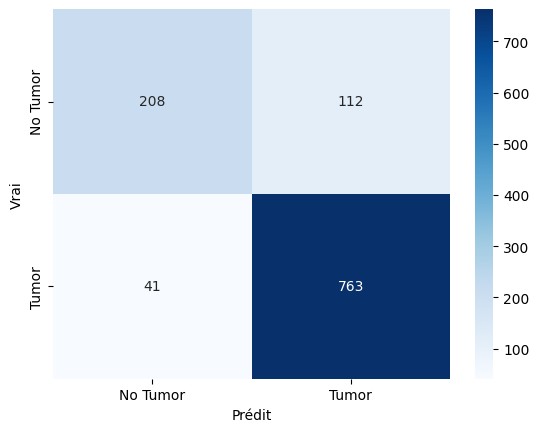


AUC-ROC: 0.9116



In [ ]:
# 6. Évaluation
def evaluate_model(model, X_test, y_test):
    """Évalue le modèle et affiche les métriques"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("\n" + "="*50)
    print("Rapport de classification:")
    print(classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor']))

    print("\nMatrice de confusion:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Tumor', 'Tumor'],
                yticklabels=['No Tumor', 'Tumor'])
    plt.ylabel('Vrai')
    plt.xlabel('Prédit')
    plt.show()

    print(f"\nAUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
    print("="*50 + "\n")

print("Évaluation sur le jeu de test:")
evaluate_model(rf_model, X_test, y_test)

Importance des caractéristiques (Feature Importance)


Top 10 des features les plus importantes:
Feature 2: 0.0203
Feature 6: 0.0198
Feature 4: 0.0138
Feature 1: 0.0119
Feature 5: 0.0081
Feature 2124: 0.0074
Feature 2095: 0.0058
Feature 3: 0.0057
Feature 17: 0.0055
Feature 2092: 0.0054


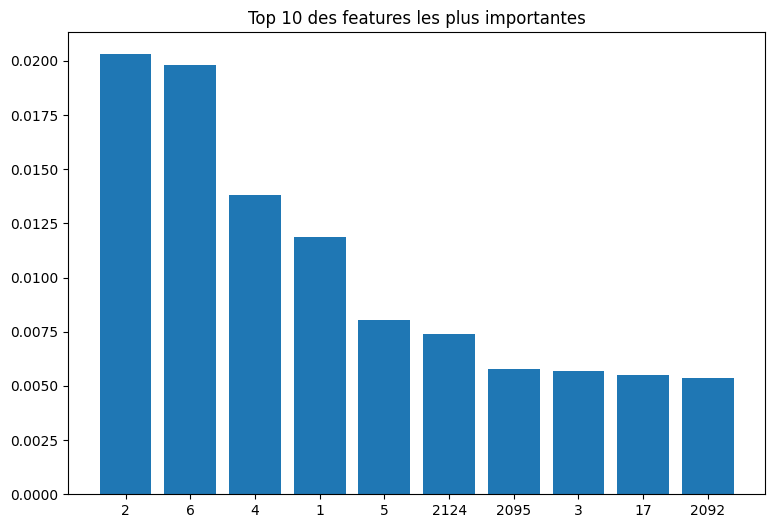

In [ ]:
# 7. Feature Importance
if hasattr(rf_model, 'feature_importances_'):
    print("\nTop 10 des features les plus importantes:")
    importances = rf_model.feature_importances_
    top_indices = np.argsort(importances)[-10:][::-1]

    for idx in top_indices:
        print(f"Feature {idx}: {importances[idx]:.4f}")

    plt.figure(figsize=(9, 6))
    plt.bar(range(10), importances[top_indices])
    plt.xticks(range(10), top_indices)
    plt.title("Top 10 des features les plus importantes")
    plt.show()

Sauvegarde du modèle Random Forest et du transformateur PCA

In [ ]:
# 8. Sauvegarde du modèle
model_path = '/content/drive/MyDrive/data/random_forest_model.joblib'
joblib.dump(rf_model, model_path)
print(f"\nModèle sauvegardé à : {model_path}")

# Si PCA a été appliqué, sauvegarder aussi le transformateur PCA
if 'pca' in locals():
    pca_path = '/content/drive/MyDrive/data/pca_transformer.joblib'
    joblib.dump(pca, pca_path)
    print(f"Transformateur PCA sauvegardé à : {pca_path}")


Modèle sauvegardé à : /content/drive/MyDrive/data/random_forest_model.joblib
Transformateur PCA sauvegardé à : /content/drive/MyDrive/data/pca_transformer.joblib


Code pour visualiser l'accuracy et la perte (Learning Curves)

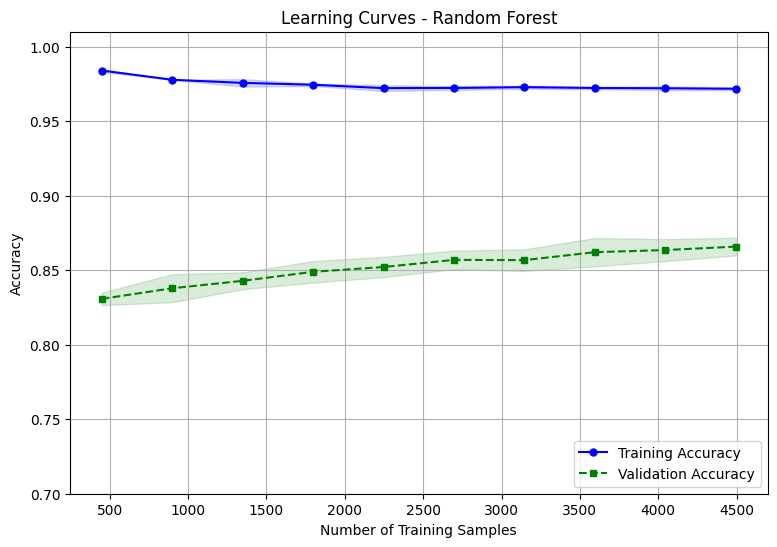

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Configuration des courbes d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model,
    X=X_processed,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

# Calcul des moyennes et écarts-types
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracé des courbes
plt.figure(figsize=(9, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Learning Curves - Random Forest')
plt.ylim([0.7, 1.01])
plt.show()

Code pour afficher l'accuracy finale avec visualisation


                 Accuracy Finale                  
Jeu dentraînement             : 0.9709
Jeu de test                   : 0.8639



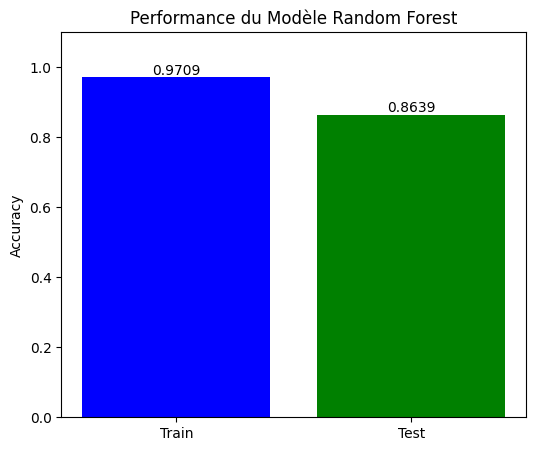

In [ ]:
from sklearn.metrics import accuracy_score

# Prédictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calcul des accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Affichage stylisé
print("\n" + "="*50)
print(f"{'Accuracy Finale':^50}")
print("="*50)
print(f"{'Jeu dentraînement':<30}: {train_accuracy:.4f}")
print(f"{'Jeu de test':<30}: {test_accuracy:.4f}")
print("="*50 + "\n")

# Visualisation graphique
plt.figure(figsize=(6, 5))
bars = plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'green'])

plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Performance du Modèle Random Forest')

# Ajout des valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.show()

Recherche des meilleurs hyperparamètres pour le Random Forest avec GridSearchCV et évaluation finale

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Dictionnaire d'hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

# Instanciation du modèle de base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Configuration du GridSearch
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                        # Validation croisée à 3 plis
    scoring='accuracy',         # Ou 'f1', 'roc_auc', selon ton objectif
    verbose=2,
    n_jobs=-1                   # Utilisation maximale des cœurs CPU
)

# Entraînement
print("🔍 Recherche des meilleurs hyperparamètres...")
grid_search.fit(X_train, y_train)

# Résultats
print("\nMeilleurs paramètres trouvés :")
print(grid_search.best_params_)
print(f"Meilleure précision (CV) : {grid_search.best_score_:.4f}")

# Meilleur modèle entraîné
best_rf = grid_search.best_estimator_

# Évaluation sur le test
test_accuracy = best_rf.score(X_test, y_test)
print(f"\nPrécision sur test avec meilleur modèle : {test_accuracy:.4f}")



🔍 Recherche des meilleurs hyperparamètres...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Meilleurs paramètres trouvés :
{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 150}
Meilleure précision (CV) : 0.8601

Précision sur test avec meilleur modèle : 0.8648


Évaluation du modèle Random Forest optimisé : rapport de classification et matrice de confusion


📄 Rapport de classification :
              precision    recall  f1-score   support

           0       0.83      0.66      0.73       320
           1       0.87      0.95      0.91       804

    accuracy                           0.86      1124
   macro avg       0.85      0.80      0.82      1124
weighted avg       0.86      0.86      0.86      1124



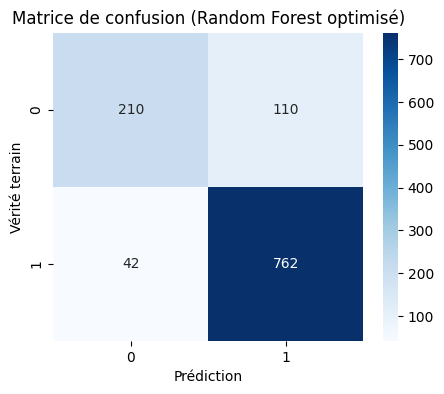

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prédiction
y_pred = best_rf.predict(X_test)

# Rapport
print("\n📄 Rapport de classification :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion (Random Forest optimisé)")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()


In [ ]:
import joblib

# Sauvegarde
joblib.dump(best_rf, '/content/drive/MyDrive/data/rf_best_model.joblib')
print("✅ Modèle sauvegardé avec succès dans Google Drive.")


✅ Modèle sauvegardé avec succès dans Google Drive.


Évaluation finale du modèle Random Forest optimisé : accuracy et visualisation graphique


        🎯 Accuracy Finale (GridSearch RF)         
Jeu dentraînement             : 0.9726
Jeu de test                   : 0.8648



/tmp/ipython-input-25-829241242.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


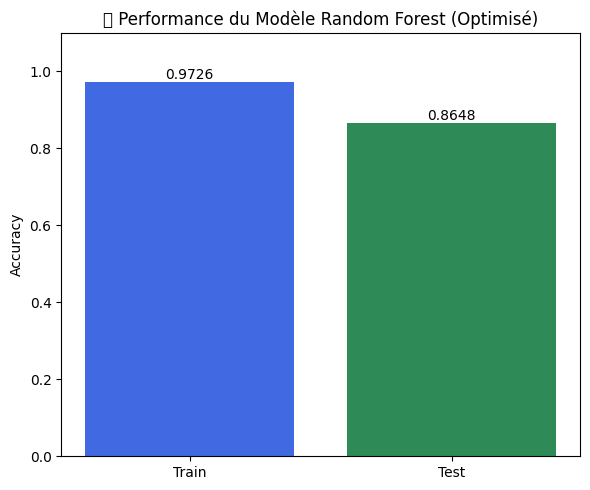

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# --- 1. Prédictions avec le modèle GridSearchCV ---
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# --- 2. Accuracy ---
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# --- 3. Affichage formaté ---
print("\n" + "="*50)
print(f"{'🎯 Accuracy Finale (GridSearch RF)':^50}")
print("="*50)
print(f"{'Jeu dentraînement':<30}: {train_accuracy:.4f}")
print(f"{'Jeu de test':<30}: {test_accuracy:.4f}")
print("="*50 + "\n")

# --- 4. Visualisation graphique ---
plt.figure(figsize=(6, 5))
bars = plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['royalblue', 'seagreen'])

plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('📊 Performance du Modèle Random Forest (Optimisé)')

# Valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


Courbes d'apprentissage du modèle Random Forest optimisé (accuracy vs taille du jeu d'entraînement)

/tmp/ipython-input-27-3345078991.py:41: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


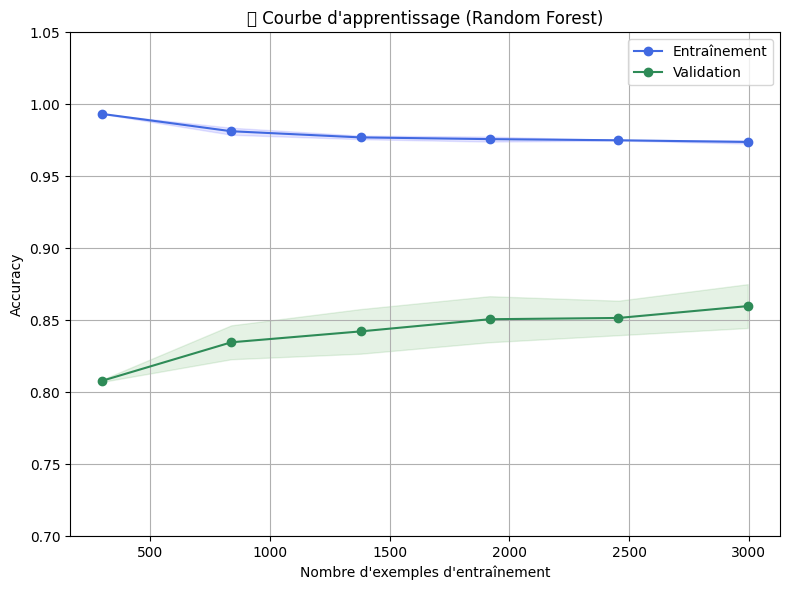

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# --- Courbe d'apprentissage ---
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_rf,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 6),  # 10% à 100% du jeu d'entraînement
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Moyennes et écart-types
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

# --- Plot ---
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='royalblue', label='Entraînement')
plt.plot(train_sizes, test_scores_mean, 'o-', color='seagreen', label='Validation')

# Zones d'incertitude
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='green')

plt.title("📈 Courbe d'apprentissage (Random Forest)")
plt.xlabel("Nombre d'exemples d'entraînement")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.05)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Classification d'images avec SVM : Chargement, Prétraitement et Standardisation des Données

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
# 1. Chargement des données
X = np.load('/content/drive/MyDrive/data/preprocessed/X_train.npy')[:2000]
y = np.load('/content/drive/MyDrive/data/preprocessed/y_train.npy')[:2000]
# Flatten
X = X.reshape((X.shape[0], -1))

# 2. Train/test split + normalisation
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [2]:
# 3. PCA moins coûteux
from sklearn.decomposition import IncrementalPCA
pca = IncrementalPCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [3]:
# 6. Définition du modèle SVM + GridSearchCV
print("Optimisation du modèle SVM avec GridSearch...")
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
start_time = time.time()
grid.fit(X_train_pca, y_train)
end_time = time.time()

print(f"\nTemps d'entraînement: {end_time - start_time:.2f} secondes")
print(f"Meilleurs hyperparamètres: {grid.best_params_}")

Optimisation du modèle SVM avec GridSearch...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Temps d'entraînement: 48.03 secondes
Meilleurs hyperparamètres: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [4]:
# . Évaluation du modèle
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_pca)
y_proba = best_model.predict_proba(X_test_pca)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.90       121
           1       0.94      0.98      0.96       279

    accuracy                           0.94       400
   macro avg       0.94      0.91      0.93       400
weighted avg       0.94      0.94      0.94       400




Matrice de confusion:


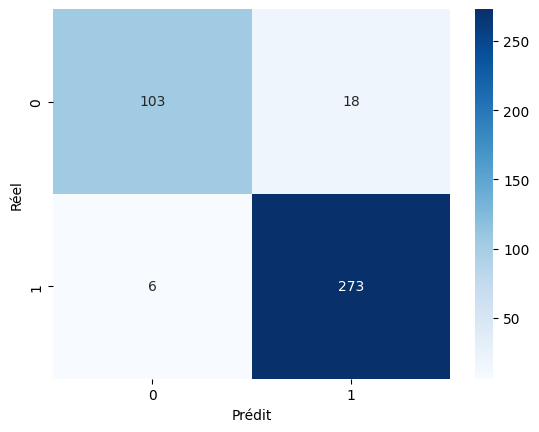

In [5]:
print("\nMatrice de confusion:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

In [6]:
auc_score = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {auc_score:.4f}")


ROC AUC Score: 0.9794


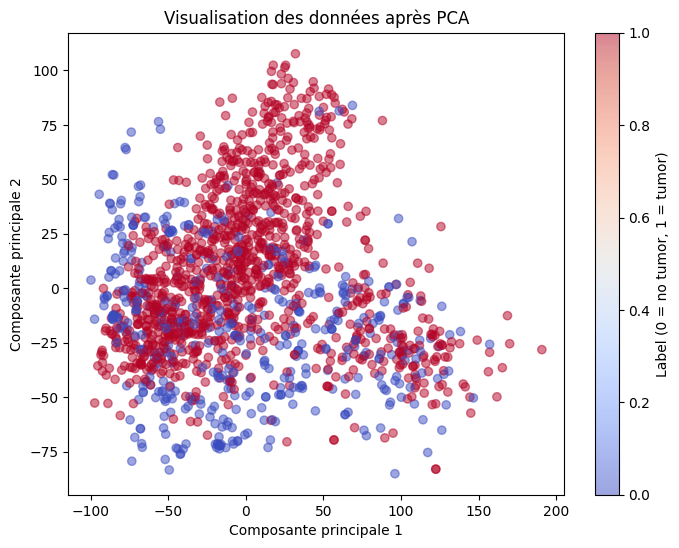

In [7]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.5)
plt.title("Visualisation des données après PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.colorbar(scatter, label='Label (0 = no tumor, 1 = tumor)')
plt.show()

In [8]:
from sklearn.metrics import RocCurveDisplay, accuracy_score

#  1. Accuracy finale
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_proba)
print(f"\nAccuracy : {accuracy:.4f}")
print(f"ROC AUC : {auc_score:.4f}")



Accuracy : 0.9400
ROC AUC : 0.9794


In [13]:
# Sauvegarde du modèle SVM, scaler et PCA
joblib.dump(best_model, '/content/drive/MyDrive/data/svm_brain_model.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/data/scaler.pkl')
joblib.dump(pca, '/content/drive/MyDrive/data/pca.pkl')

print("\n✅ Modèle, scaler et PCA sauvegardés avec succès !")



✅ Modèle, scaler et PCA sauvegardés avec succès !


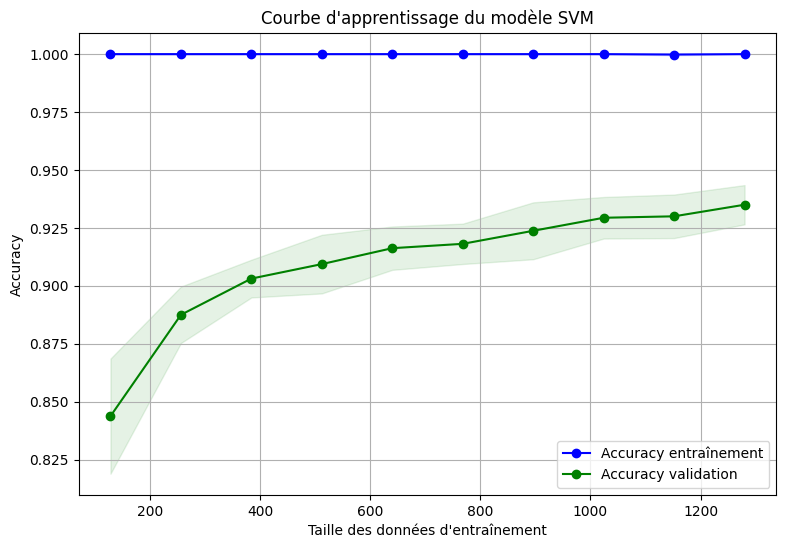

In [15]:
from sklearn.model_selection import learning_curve

# Génération des courbes d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train_pca, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

# Moyenne et écart type
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

train_scores_std = np.std(train_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(9, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Accuracy entraînement')
plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Accuracy validation')

plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color="blue")
plt.fill_between(train_sizes,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std,
                 alpha=0.1, color="green")

plt.title("Courbe d'apprentissage du modèle SVM")
plt.xlabel("Taille des données d'entraînement")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


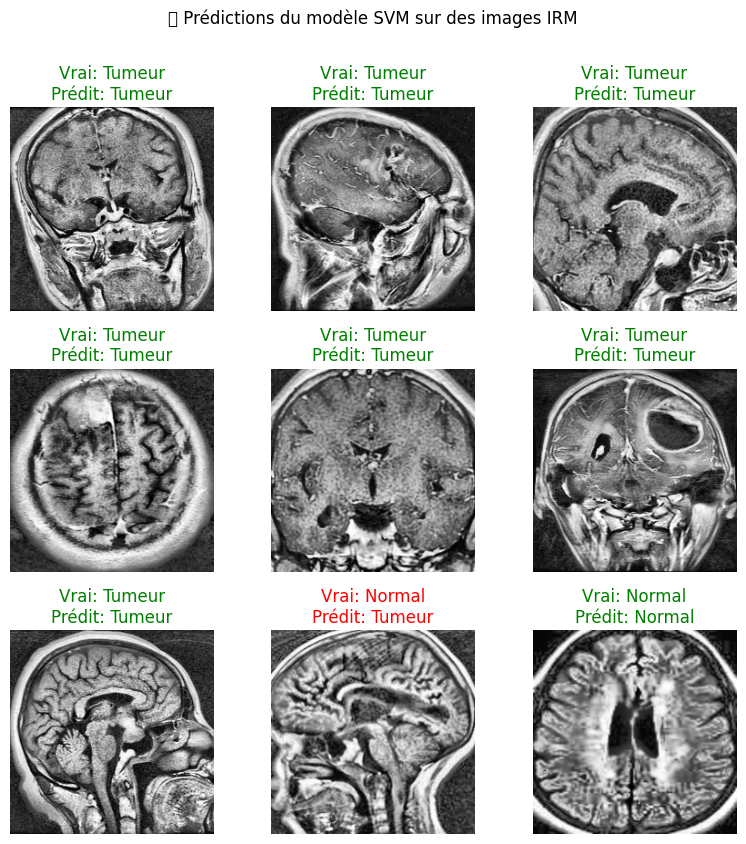

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Chargement des classes
class_names = ['Normal', 'Tumeur']

# 1. Recharger les images brutes (non flattenées)
X_raw = np.load('/content/drive/MyDrive/data/preprocessed/X_train.npy')[:2000]
y_raw = np.load('/content/drive/MyDrive/data/preprocessed/y_train.npy')[:2000]

# 2. Supprimer la dimension du canal si elle existe
if X_raw.ndim == 4 and X_raw.shape[-1] == 1:
    X_raw = X_raw.squeeze(-1)
elif X_raw.ndim == 4 and X_raw.shape[-1] == 3:
    X_raw = np.mean(X_raw, axis=-1)  # Convertir RGB en gris si besoin

# 3. Refait le même split que pour l'entraînement
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(
    X_raw, y_raw, stratify=y_raw, test_size=0.2, random_state=42
)

# 4. Prédictions déjà faites avec SVM (y_pred)
# S'assurer que y_pred a été défini avec best_model.predict(X_test_pca)
# Exemple :
# y_pred = best_model.predict(X_test_pca)

# 5. Affichage de 9 exemples aléatoires
plt.figure(figsize=(8, 8))
for i in range(9):
    idx = np.random.randint(len(X_raw_test))
    image = X_raw_test[idx]
    true_label = y_raw_test[idx]
    pred_label = y_pred[idx]  # prédiction déjà faite plus tôt

    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"Vrai: {class_names[true_label]}\nPrédit: {class_names[pred_label]}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("🎯 Prédictions du modèle SVM sur des images IRM", y=1.05)
plt.show()


Classification IRM avec XGBoost

Installation

In [1]:
!pip install xgboost


Importation des bibliothèques

In [2]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


Chargement et Prétraitement des Données

In [3]:
# Charger les données (extrait de 2000 exemples)
X = np.load('/content/drive/MyDrive/data/preprocessed/X_train.npy')[:2000]
y = np.load('/content/drive/MyDrive/data/preprocessed/y_train.npy')[:2000]

# Aplatir les images (passage en 2D)
X = X.reshape((X.shape[0], -1))

# Séparer train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Définition et Entraînement du Modèle XGBoost + GridSearch

In [4]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Définir un modèle XGBoost léger
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    verbosity=1
)

Évaluation du Meilleur Modèle

In [5]:
# 2. Entraînement
print("🔁 Entraînement du modèle XGBoost (léger)...")
xgb_model.fit(X_train_scaled, y_train)

# 3. Prédictions
y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

🔁 Entraînement du modèle XGBoost (léger)...


In [6]:
# 4. Évaluation
print("\n📊 Rapport de classification :")
print(classification_report(y_test, y_pred))
print(f"🎯 ROC AUC : {roc_auc_score(y_test, y_proba):.4f}")


📊 Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.82      0.88       121
           1       0.93      0.99      0.95       279

    accuracy                           0.94       400
   macro avg       0.94      0.90      0.92       400
weighted avg       0.94      0.94      0.93       400

🎯 ROC AUC : 0.9848


Sauvegarde du Modèle et du Scaler

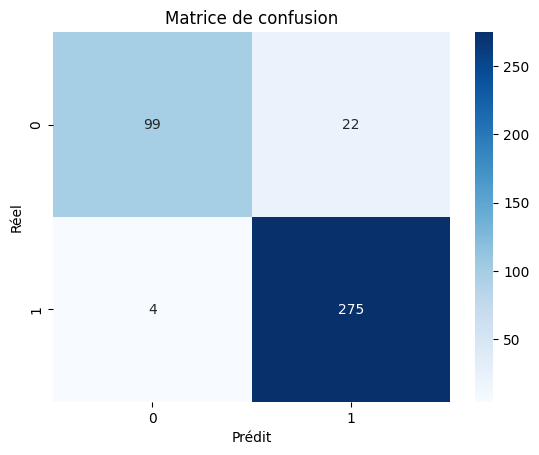

In [8]:
# 5. Matrice de confusion
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()


In [10]:
import joblib

# Chemin vers ton Drive (à adapter si besoin)
model_path = '/content/drive/MyDrive/data/xgb_model_brain_tumor.joblib'

# Sauvegarder le modèle dans Google Drive
joblib.dump(xgb_model, model_path)
print(f"Modèle sauvegardé dans : {model_path}")


Modèle sauvegardé dans : /content/drive/MyDrive/data/xgb_model_brain_tumor.joblib


In [11]:
# --- Fonction pour tester une image IRM individuelle ---
def test_single_image(preprocessed_image, model, scaler):
    """
    Prétraitée, redimensionnée et normalisée image IRM (H, W)
    model : modèle XGBoost entraîné
    scaler : StandardScaler utilisé sur les données
    """
    x = preprocessed_image.reshape(1, -1)             # Aplatir
    x_scaled = scaler.transform(x)                     # Normaliser
    pred_class = model.predict(x_scaled)[0]
    pred_prob = model.predict_proba(x_scaled)[0, 1]
    return pred_class, pred_prob

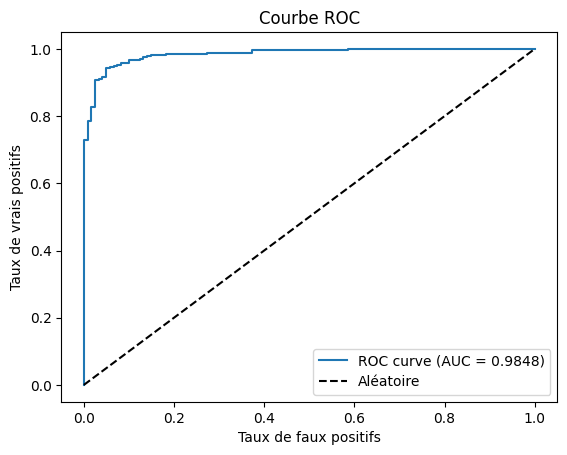

In [12]:
# --- Affichage de la courbe ROC / AUC ---
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Aléatoire")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.show()